Author: Kaede Kimura

Article title (tentative): _Evaluation of a Deep-learning Approach to Automatically Monitor Frog Reproductive Phenology_

In [1]:
from fastai.vision.all import *
import sklearn.metrics as skm

# Sound Classification with DNN

瓜生と京大の２地点で、ヒキ・シュレ・トノサマ・アマ・ツチの５種を識別するCNNモデルを訓練する。

In [2]:
# Compose a DataBlock
def get_multi_y(x): return parent_label(x).split("_")

dblock = DataBlock(blocks = (ImageBlock, MultiCategoryBlock),
                   get_items = get_image_files,
                   get_y = get_multi_y,
                   splitter = GrandparentSplitter(train_name="train", valid_name="valid")
                   )

Traininigとvalidationのデータセットのサイズを確認する。

In [3]:
dsets = dblock.datasets("training/high-temporal-res-melspectrogram")

print("Training dataset: ", len(dsets.train))
print("Validation dataset: ", len(dsets.valid))
print("Type of data: ", dsets.valid[0])

Training dataset:  2565
Validation dataset:  190
Type of data:  (PILImage mode=RGB size=861x128, TensorMultiCategory([0., 0., 0., 0., 0., 1.]))


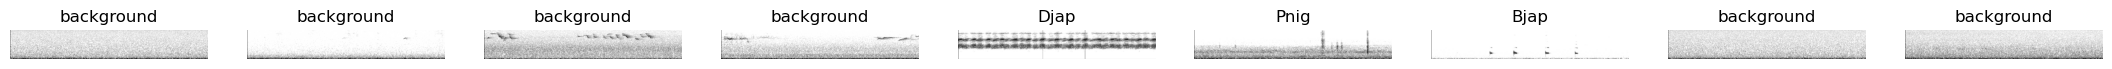

In [5]:
# DataLoaders
dls = dblock.dataloaders("training/high-temporal-res-melspectrogram")
dls.train.show_batch(nrows=1)

In [6]:
dls.vocab

['Bjap', 'Djap', 'Grug', 'Pnig', 'Zsch', 'background']

## Fine tune前の転移学習ステップ

Unfreezeする前に100 epochs訓練して、様子を見る。

In [12]:
learn =vision_learner(dls, models.resnet18, metrics=accuracy_multi, pretrained = True, normalize = True)

In [13]:
learn.freeze()
learn.fit_one_cycle(100, cbs=MixUp())

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.972521,0.885448,0.525439,00:16
1,0.930564,0.669923,0.629825,00:16
2,0.891772,0.626704,0.667544,00:16
3,0.857344,0.606158,0.684211,00:16
4,0.819151,0.553277,0.728947,00:16
5,0.778360,0.523160,0.749123,00:16
6,0.736197,0.516457,0.766667,00:15
7,0.689555,0.479840,0.799123,00:15
8,0.643073,0.444908,0.839474,00:16
9,0.587385,0.402683,0.857018,00:16


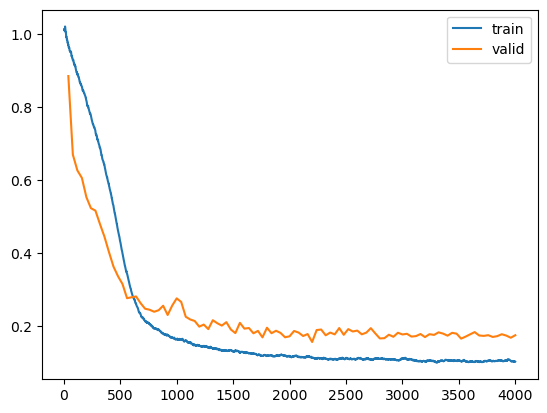

In [14]:
learn.recorder.plot_loss()

SuggestedLRs(valley=1.4454397387453355e-05)

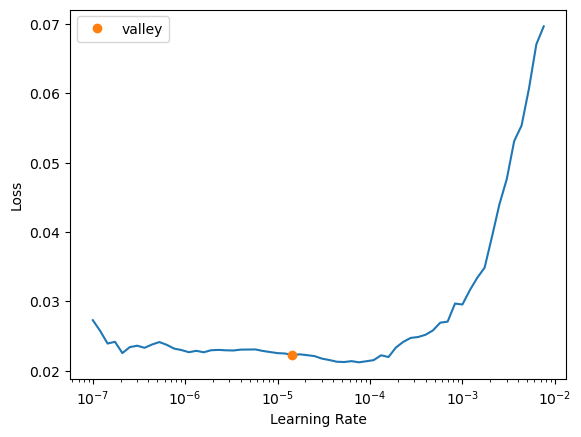

In [15]:
learn.unfreeze()
learn.lr_find()

## 本番｜訓練

最初の10エポックはfreezeして学習を行い、続く100エポックはunfreezeして学習させる。

In [17]:
learn =vision_learner(dls, models.resnet18, metrics=accuracy_multi, pretrained = True, normalize = True)

In [18]:
learn.fine_tune(epochs=150, freeze_epochs=10, cbs=MixUp())

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.955737,0.918469,0.541228,00:16
1,0.881614,0.610432,0.667544,00:16
2,0.810792,0.549026,0.733333,00:16
3,0.723827,0.482818,0.792105,00:16
4,0.607042,0.380227,0.860526,00:16
5,0.479720,0.332221,0.875439,00:16
6,0.366120,0.325388,0.864912,00:16
7,0.296380,0.318824,0.878070,00:16
8,0.254447,0.318764,0.874561,00:16
9,0.228764,0.316208,0.878947,00:16


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.199681,0.264780,0.898246,00:18
1,0.187275,0.280144,0.890351,00:18
2,0.176779,0.259628,0.896491,00:19
3,0.170898,0.250893,0.911404,00:18
4,0.163362,0.249165,0.916667,00:18
5,0.160518,0.252490,0.907895,00:18
6,0.154590,0.240511,0.919298,00:18
7,0.147189,0.262058,0.912281,00:18
8,0.144174,0.231858,0.922807,00:19
9,0.140876,0.228574,0.922807,00:18


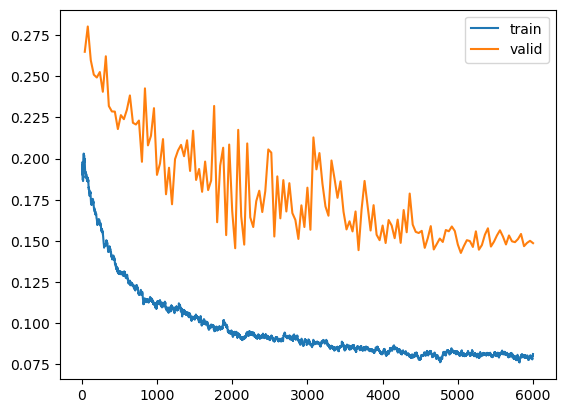

In [19]:
learn.recorder.plot_loss()

### Model metrics

In [21]:
preds, targ = learn.get_preds(ds_idx=1)

print(skm.classification_report(targ[:,:5], preds[:,:5]>0.5, target_names=dls.vocab[:5]))
print("AUC score" + str(skm.roc_auc_score(targ, preds, average="macro")))

              precision    recall  f1-score   support

        Bjap       1.00      0.90      0.95        40
        Djap       0.97      0.93      0.95        40
        Grug       0.92      0.82      0.87        40
        Pnig       0.90      0.68      0.77        40
        Zsch       1.00      0.97      0.99        40

   micro avg       0.96      0.86      0.91       200
   macro avg       0.96      0.86      0.90       200
weighted avg       0.96      0.86      0.90       200
 samples avg       0.69      0.68      0.68       200

AUC score0.9844444444444443


C:\Users\kburo\anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kburo\anaconda3\envs\fastai\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


精度は高い。いい感じ。しかしハイパスしたものよりはほんのわずかに低い。

In [22]:
learn.export("output/20220103_trained-model.pkl")